In [1]:
# continuously load modules (for easier debugging)
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from irl.dagger import dagger
from corels import *
from irl.utils import corels_policy_generator, bin_states, bin_states_pctile

In [3]:
class WaypointWorld():
    def __init__(self):
        # (x, y)
        self.state = np.array([0, 0])
        self.xmin = 0
        self.xmax = 10
        self.ymin = 0
        self.ymax = 10
    
    def reset(self):
        self.state = np.array([0, 0])
    
    def observe(self):
        return self.state
    
    def perform(self, action):
        """
        [0, 1, 2, 3] => down, up, right, left
        """
        x, y = self.state
        if action == 0: # down
            self.state = np.array([x, max(self.ymin, y - 1)])
        elif action == 1: # up
            self.state = np.array([x, min(self.ymax, y + 1)])
        elif action == 2: # right
            self.state = np.array([min(self.xmax, x + 1), y])
        elif action == 3: # left
            self.state = np.array([max(self.xmin, x - 1), y])
        else:
            raise ValueError(f'Unexpected action {action}')

        if (self.state == np.array([10, 10])).all():
            r = 100
            self.reset()
        else:
            r = -1
            
        return r, self.state
    
pi_b_waypoints = [(1, 2), (7, 4), (3, 6), (6, 8), (10, 10)]
pi_blackbox_waypoints = [(1, 2), (2, 4), (3, 6), (6, 8), (10, 10)]
    
def pi(s, waypoints):
    """ s = state = (x, y)"""
    s_x, s_y = s
    ind = int(s_y / 2)
    ind = ind - 1 if ind >= len(waypoints) else ind
    wp_x, wp_y = waypoints[ind]
    a_x = wp_x - s_x
    a_y = wp_y - s_y   
    return (a_x / np.sqrt(a_x**2 + a_y**2), a_y / np.sqrt(a_x**2 + a_y**2))

In [4]:
def plot_policy(waypoints):
    plt.axis([0, 10, 0, 10])
    for (x, y) in waypoints:
        plt.plot(x, y, 'bo')
    for i in np.arange(0.0, 10.0, 0.5):
        for j in np.arange(0, 10.0, 0.5):
            dx, dy = pi((i, j), waypoints)
            plt.arrow(i, j, dx, dy, head_width=0.2, head_length=0.5, fc='k', ec='k')
    plt.show()

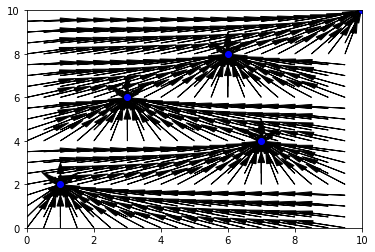

In [5]:
plot_policy(pi_b_waypoints)

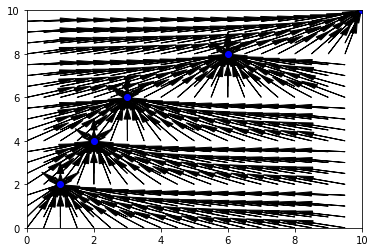

In [6]:
plot_policy(pi_blackbox_waypoints)

# CORELS

In [7]:
def pi(s, waypoints):
    """ s = state = (x, y)"""
    s_x, s_y = s
    ind = int(s_y / 2)
    ind = ind - 1 if ind >= len(waypoints) else ind
    wp_x, wp_y = waypoints[ind]
    a_x = wp_x - s_x
    a_y = wp_y - s_y   
    
    # CHANGED: had to output discrete actions for CORELS
    if np.abs(a_x) > np.abs(a_y):
        # left/right
        if a_x > 0:
            return 2
        else:
            return 3
    else:
        # up/down
        if a_y > 0:
            return 1
        else:
            return 0

In [8]:
blackbox_policy = lambda s: pi(s, pi_blackbox_waypoints)

corels_policy = lambda X, y: corels_policy_generator(
    X, y, nbins=5, maxiter=10000, max_card=2, min_support=0.01, c_reg=0.000001
)

imit_policy, eval_score, model = dagger(blackbox_policy, corels_policy, WaypointWorld(), N=2)

model score on training set for action 0: 1.0
model score on training set for action 1: 0.8
model score on training set for action 2: 0.8
model score on training set for action 3: 1.0
evaluation: 810
model score on training set for action 0: 1.0
model score on training set for action 1: 0.8
model score on training set for action 2: 0.8
model score on training set for action 3: 1.0
evaluation: 810



In [9]:
for i, m in enumerate(model):
    print(f'\nAction {i}')
    print(m.rl())


Action 0
RULELIST:
prediction = False

Action 1
RULELIST:
if [State 1: 3.6 to 5.4 && not State 2: 8.0 to 1e+01]:
  prediction = True
else if [State 2: 6.0 to 8.0 && not State 1: 7.2 to 9.0]:
  prediction = False
else if [State 1: 7.2 to 9.0 && not State 2: 6.0 to 8.0]:
  prediction = False
else 
  prediction = True

Action 2
RULELIST:
if [State 1: 3.6 to 5.4 && not State 2: 8.0 to 1e+01]:
  prediction = False
else if [State 2: 6.0 to 8.0 && not State 1: 7.2 to 9.0]:
  prediction = True
else if [State 1: 7.2 to 9.0 && not State 2: 6.0 to 8.0]:
  prediction = True
else 
  prediction = False

Action 3
RULELIST:
prediction = False
